Adapted from https://developers.google.com/machine-learning/foundational-courses

# Introduction to Neural Networks

## 17 October 2023

# Let's review

Consider the following two plots:

![mse plots](assets/mse.png)

Which of the two data sets shown above has the higher Mean Squared Error (MSE)? 

# Reducing Loss

![iterative process for minimizing loss](assets/iterative-loss.svg)

- A Machine Learning model is trained by starting with an initial guess for the weights and bias and iteratively adjusting those guesses until learning the weights and bias with the lowest possible loss
    - These values are commonly randomly initialized
    - Can also be 0-initialized
    - Other strategies exist, but we won't go too far into them
- We iterate until overall loss stops changing, or changes extremely slowly
    - When this happens, we say that the model has **converged**

# Gradients

- The gradient of a function, denoted $\nabla f$, is the vector of partial derivatives with respect to all of the independent variables
    - $\nabla f$ points in the direction of **greatest increase** of the function
    - $-\nabla f$ points in the direction of **greatest decrease** of the function
- The number of dimensions in the vector is equal to the number of variables in the formula for $f$
- A gradient is a vector, so it has both a **direction** and a **magnitude**

# Gradient Descent

![](assets/convex.svg)

![](assets/gradient-descent-start.svg)

![](assets/gradient-descent-neg-grad.svg)

![](assets/gradient-descent-descent-step.svg)

![](assets/three-dimensional-plot.svg)

# Learning Rate

- Gradient descent algorithms multiply the gradient by a scalar known as the **learning rate** (also called **step size**) to determine the next point
- Learning rate is what's known as a model **hyperparameter**
    - Hyperparameters refer broadly to ways to alter how a model trains, without affecting its formal structure
- This is one of the most important hyperparameters to optimize since too small or too large of a value can prevent your model from converging

<img src="assets/lr-small.svg" width="40%" /> <img src="assets/lr-large.svg" width="50%" />

# Introduction to Neural Networks

Recall the equation for a multiple regression from last week:

$$
y_{i} = \beta_{0} + \beta_{1}x_{i,1}+\beta_{2}x_{i,2} + \ldots + \beta_{n}x_{i,n}
$$

Simplified to $Y=X\beta+\epsilon$

A single neuron in a neural network is fundamentally similar:

<img src="assets/single-neuron.png" width="50%" />

A **neural network** is then just a composition of these individual neurons:

<img src="assets/network.svg" width="50%" />

# Starting with TensorFlow

![tensorflow hierarchy](assets/tf-hierarchy.png)

# A Regression in TensorFlow

```python
model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.Dense(
        units=1, 
        input_shape=(1,)
))
model.compile(
    optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),
    loss="mean_squared_error",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
```

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
training_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
training_df["median_house_value"] /= 1000.0
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66.9
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80.1
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85.7
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73.4
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65.5


In [3]:
def build_model(my_learning_rate):
    """Create and compile a simple linear regression model."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Describe the topography of the model.
    # The topography of a simple linear regression model
    # is a single node in a single layer.
    model.add(
        tf.keras.layers.Dense(
            units=1,
            input_shape=(1,)
        )
    )

    # Compile the model topography into code that TensorFlow can efficiently
    # execute. Configure training to minimize the model's mean squared error. 
    model.compile(
        optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model        


def train_model(model, df, feature, label, epochs, batch_size):
    """Train the model by feeding it data."""

    # Feed the model the feature and the label.
    # The model will train for the specified number of epochs. 
    history = model.fit(
        x=df[feature],
        y=df[label],
        batch_size=batch_size,
        epochs=epochs)

    # Gather the trained model's weight and bias.
    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the error for each epoch.
    hist = pd.DataFrame(history.history)

    # To track the progression of training, we're going to take a snapshot
    # of the model's root mean squared error at each epoch. 
    rmse = hist["root_mean_squared_error"]

    return trained_weight, trained_bias, epochs, rmse

In [17]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
    """Plot the trained model against 200 random training examples."""

    # Label the axes.
    plt.xlabel(feature)
    plt.ylabel(label)

    # Create a scatter plot from 200 random points of the dataset.
    random_examples = training_df.sample(n=200)
    plt.scatter(random_examples[feature], random_examples[label])

    # Create a red line representing the model. The red line starts
    # at coordinates (x0, y0) and ends at coordinates (x1, y1).
    x0 = 0
    y0 = trained_bias
    x1 = random_examples[feature].max()
    y1 = trained_bias + (trained_weight * x1)
    try:
        plt.plot(np.asanyarray([x0, x1]), np.asanyarray([y0, y1]), c='r')
    except ValueError:
        pass

    # Render the scatter plot and the red line.
    plt.show()


def plot_the_loss_curve(epochs, rmse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.97, rmse.max()])
    plt.show()  

In [10]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 30
batch_size = 30

my_feature = "total_rooms"
my_label="median_house_value"
my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(
    my_model, training_df, 
    my_feature, my_label,
    epochs, batch_size)

Epoch 1/30
567/567 [==============================] - 0s 510us/step - loss: 1481041.8750 - root_mean_squared_error: 1216.9806
Epoch 2/30
567/567 [==============================] - 0s 510us/step - loss: 27757.3516 - root_mean_squared_error: 166.6054
Epoch 3/30
567/567 [==============================] - 0s 494us/step - loss: 26894.2812 - root_mean_squared_error: 163.9948
Epoch 4/30
567/567 [==============================] - 0s 642us/step - loss: 26365.5410 - root_mean_squared_error: 162.3747
Epoch 5/30
567/567 [==============================] - 0s 497us/step - loss: 25656.1582 - root_mean_squared_error: 160.1754
Epoch 6/30
567/567 [==============================] - 0s 501us/step - loss: 24830.4668 - root_mean_squared_error: 157.5769
Epoch 7/30
567/567 [==============================] - 0s 499us/step - loss: 24258.8047 - root_mean_squared_error: 155.7524
Epoch 8/30
567/567 [==============================] - 0s 494us/step - loss: 23659.9746 - root_mean_squared_error: 153.8180
Epoch 9/30
56

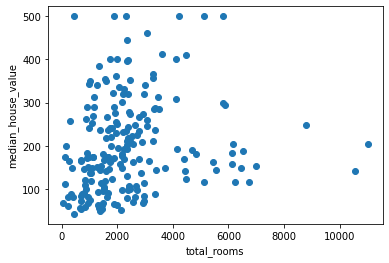

In [18]:
plot_the_model(weight, bias, my_feature, my_label)

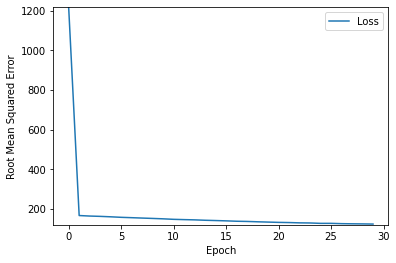


The learned weight for your model is 0.0063
The learned bias for your model is 132.3164



In [26]:
plot_the_loss_curve(epochs, rmse)
print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

In [23]:
def predict_house_values(n, feature, label):
    """Predict house values based on a feature."""

    batch = training_df[feature][10000:10000 + n]
    predicted_values = my_model.predict_on_batch(x=batch)

    print("feature   label          predicted")
    print("  value   value          value")
    print("          in thousand$   in thousand$")
    print("--------------------------------------")
    for i in range(n):
        print(
            "%5.0f %6.0f %15.0f" % (
                training_df[feature][10000 + i],
                training_df[label][10000 + i],
                predicted_values[i][0]
            )
        )

In [24]:
predict_house_values(10, my_feature, my_label)

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1960     53             145
 3400     92             154
 3677     69             155
 2202     62             146
 2403     80             147
 5652    295             168
 3318    500             153
 2552    342             148
 1364    118             141
 3468    128             154
